# Liesel-GAM Demo Notebook

## Setup and Imports

In [1]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [2]:
from scipy import stats

rng = np.random.default_rng(1)
x = rng.uniform(-2, 2, 200)

log_sigma = -1.0 + 0.3 * (
    0.5 * x + 15 * stats.norm.pdf(2 * (x - 0.2)) - stats.norm.pdf(x + 0.4)
)
mu = -x + np.pi * np.sin(np.pi * x)
y = mu + jnp.exp(log_sigma) * rng.normal(0.0, 1.0, 200)

df = pd.DataFrame({"y": y, "x": x})

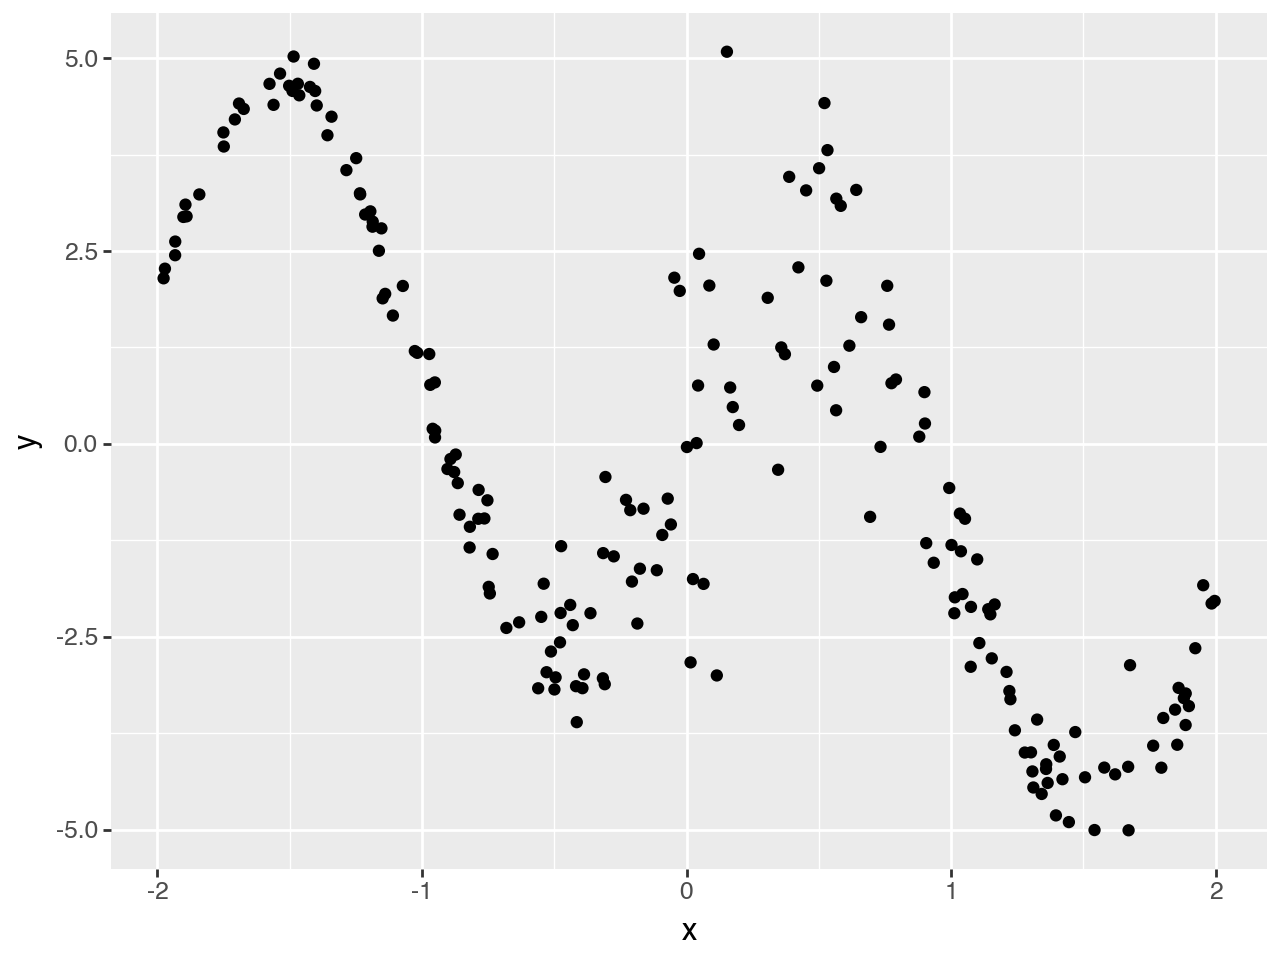

In [3]:
(p9.ggplot(df) + p9.geom_point(p9.aes("x", "y")))

## Model Definition

### Setup response model

In [4]:
loc = gam.AdditivePredictor("loc")
scale = gam.AdditivePredictor("scale", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.y.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)


registry = gam.PandasRegistry(df)
tbl = gam.TermBuilder(registry, prefix_names_by="loc.")
tbs = gam.TermBuilder(registry, prefix_names_by="scale.")

loc += tbl.np("x", k=20)
loc += tbl.lin("x")
scale += tbs.np("x", k=20)
scale += tbs.lin("x")

### Build and plot model

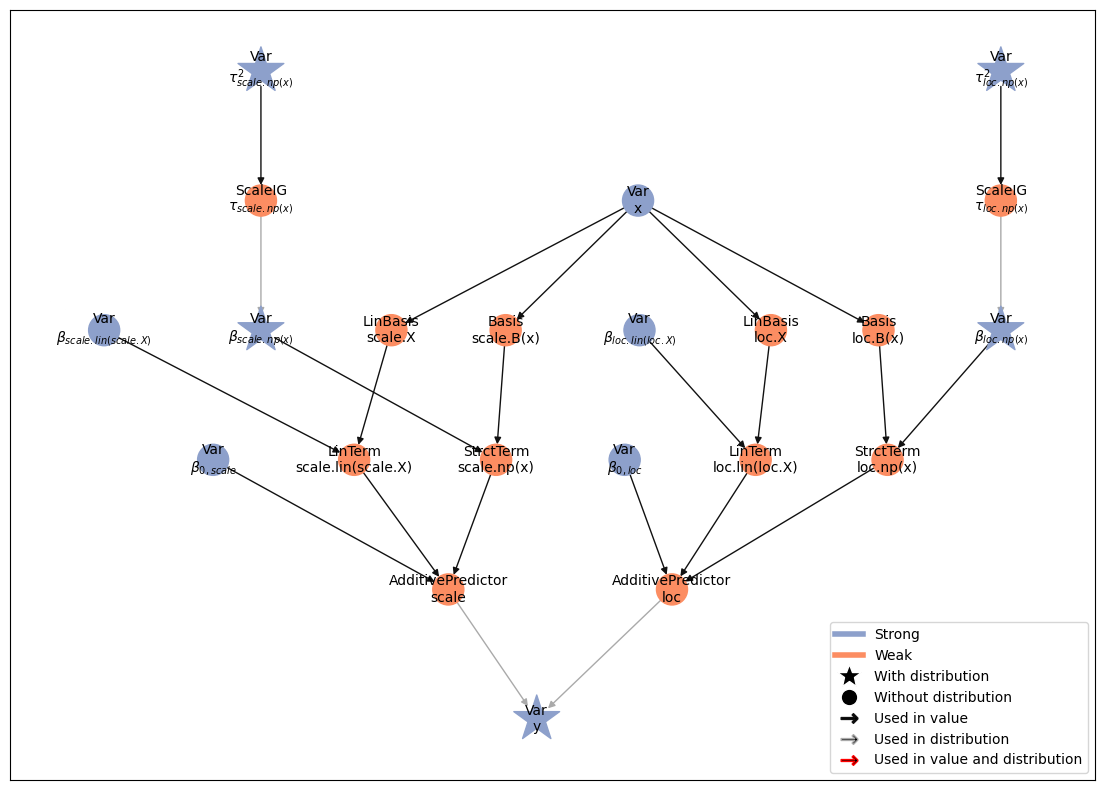

In [5]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [6]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.add_burnin(3000)
eb.add_posterior(10_000, thinning=10)

engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\beta_{0,scale}$', '$\\beta_{scale.lin(scale.X)}$', '$\\beta_{scale.np(x)}$', '$\\tau_{scale.np(x)}^2$', '$\\beta_{0,loc}$', '$\\beta_{loc.lin(loc.X)}$', '$\\beta_{loc.np(x)}$', '$\\tau_{loc.np(x)}^2$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: BURNIN, 3000 transitions, 1000 jitted together
100%|██████████████████████████████████████████| 3/3 [00:05<00:00,  1.88s/chunk]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Finished warmup
liesel.goose.engine - INFO - Starting epoch: POSTERIOR, 10000 transitions, 1000 jitted together
100%|████████████████████████████████████████| 10/10 [00:02<00:00,  3.55chunk/s]
liesel.goose.engine - INFO - Finished epoch


### MCMC summary

In [7]:
summary = gs.Summary(results)
summary

Parameter summary:

                                       kernel      mean        sd    q_0.05  \
parameter                    index                                            
$\beta_{0,loc}$              ()     kernel_04 -0.262565  0.063026 -0.367806   
$\beta_{0,scale}$            ()     kernel_00 -0.644294  0.054516 -0.733098   
$\beta_{loc.lin(loc.X)}$     (0,)   kernel_05 -1.699004  0.028991 -1.746209   
$\beta_{loc.np(x)}$          (0,)   kernel_06 -0.023772  0.058601 -0.117582   
                             (1,)   kernel_06 -0.024977  0.052526 -0.111056   
                             (2,)   kernel_06 -0.056511  0.060965 -0.157582   
                             (3,)   kernel_06  0.005730  0.040782 -0.062335   
                             (4,)   kernel_06 -0.007901  0.055968 -0.102620   
                             (5,)   kernel_06  0.045408  0.040415 -0.020446   
                             (6,)   kernel_06 -0.023389  0.050966 -0.106563   
                             (7,)   kernel_06 -0.013281  0.049341 -0.093760   
                             (8,)   kernel_06  0.007076  0.033208 -0.047084   
                             (9,)   kernel_06 -0.011697  0.038719 -0.076326   
                             (10,)  kernel_06 -0.018240  0.028765 -0.065644   
                             (11,)  kernel_06 -0.019275  0.026975 -0.063971   
                             (12,)  kernel_06 -0.010433  0.020907 -0.044253   
                             (13,)  kernel_06  0.043470  0.015434  0.018575   
                             (14,)  kernel_06 -0.202883  0.012822 -0.224227   
                             (15,)  kernel_06  0.018861  0.007626  0.006146   
                             (16,)  kernel_06 -0.019449  0.004636 -0.026990   
                             (17,)  kernel_06 -0.000499  0.001527 -0.002959   
$\beta_{scale.lin(scale.X)}$ (0,)   kernel_01  0.308974  0.049332  0.229038   
$\beta_{scale.np(x)}$        (0,)   kernel_02 -0.030080  0.036138 -0.090191   
                             (1,)   kernel_02  0.014640  0.034437 -0.040182   
                             (2,)   kernel_02 -0.007568  0.038298 -0.073435   
                             (3,)   kernel_02  0.010039  0.036874 -0.050209   
                             (4,)   kernel_02  0.003103  0.035499 -0.055316   
                             (5,)   kernel_02 -0.000883  0.034998 -0.060303   
                             (6,)   kernel_02 -0.022797  0.034212 -0.080215   
                             (7,)   kernel_02  0.012474  0.032472 -0.038521   
                             (8,)   kernel_02  0.003202  0.029793 -0.045754   
                             (9,)   kernel_02  0.007653  0.027542 -0.036162   
                             (10,)  kernel_02 -0.007116  0.026728 -0.050537   
                             (11,)  kernel_02  0.003584  0.022366 -0.033361   
                             (12,)  kernel_02 -0.028370  0.020249 -0.061930   
                             (13,)  kernel_02  0.019051  0.017124 -0.008231   
                             (14,)  kernel_02 -0.001877  0.012511 -0.021904   
                             (15,)  kernel_02  0.012170  0.007718 -0.000280   
                             (16,)  kernel_02  0.001885  0.005395 -0.006974   
                             (17,)  kernel_02  0.007870  0.001818  0.004747   
$\tau_{loc.np(x)}^2$         ()     kernel_07  0.004900  0.002147  0.002425   
$\tau_{scale.np(x)}^2$       ()     kernel_03  0.001506  0.000774  0.000672   

                                       q_0.5    q_0.95  sample_size  \
parameter                    index                                    
$\beta_{0,loc}$              ()    -0.261719 -0.159686         4000   
$\beta_{0,scale}$            ()    -0.644662 -0.552065         4000   
$\beta_{loc.lin(loc.X)}$     (0,)  -1.699281 -1.650748         4000   
$\beta_{loc.np(x)}$          (0,)  -0.024000  0.072800         4000   
                             (1,)  -0.025245  0.059996         4000   
      

### MCMC trace plots

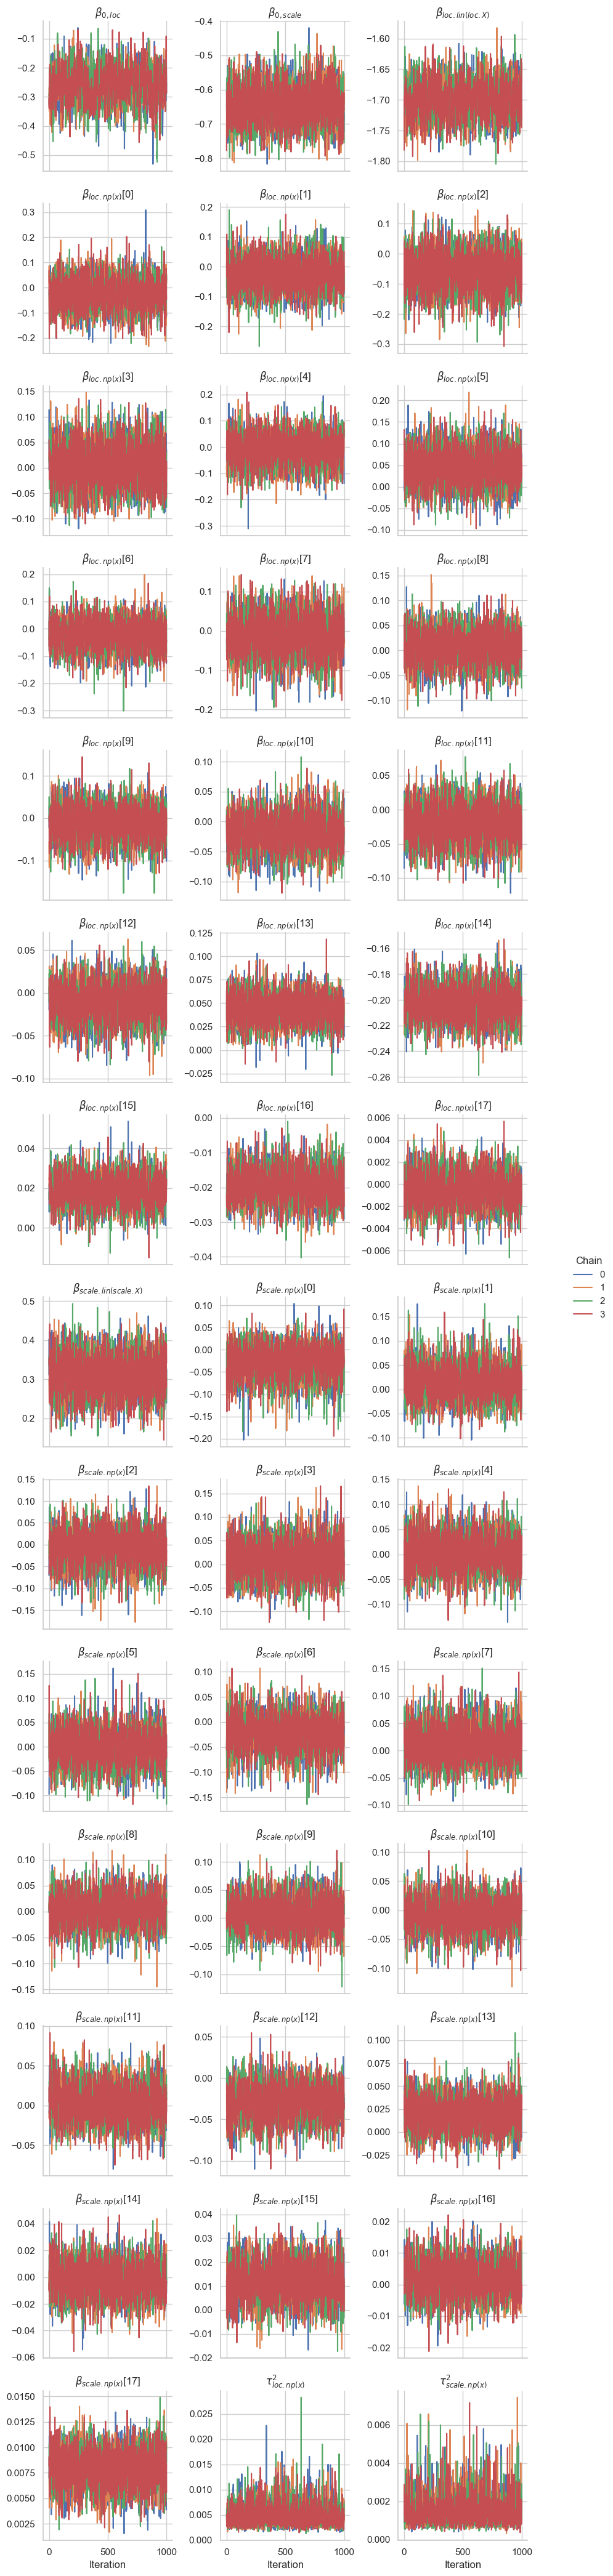

In [8]:
gs.plot_trace(results)

## Predictions

In [9]:
samples = results.get_posterior_samples()

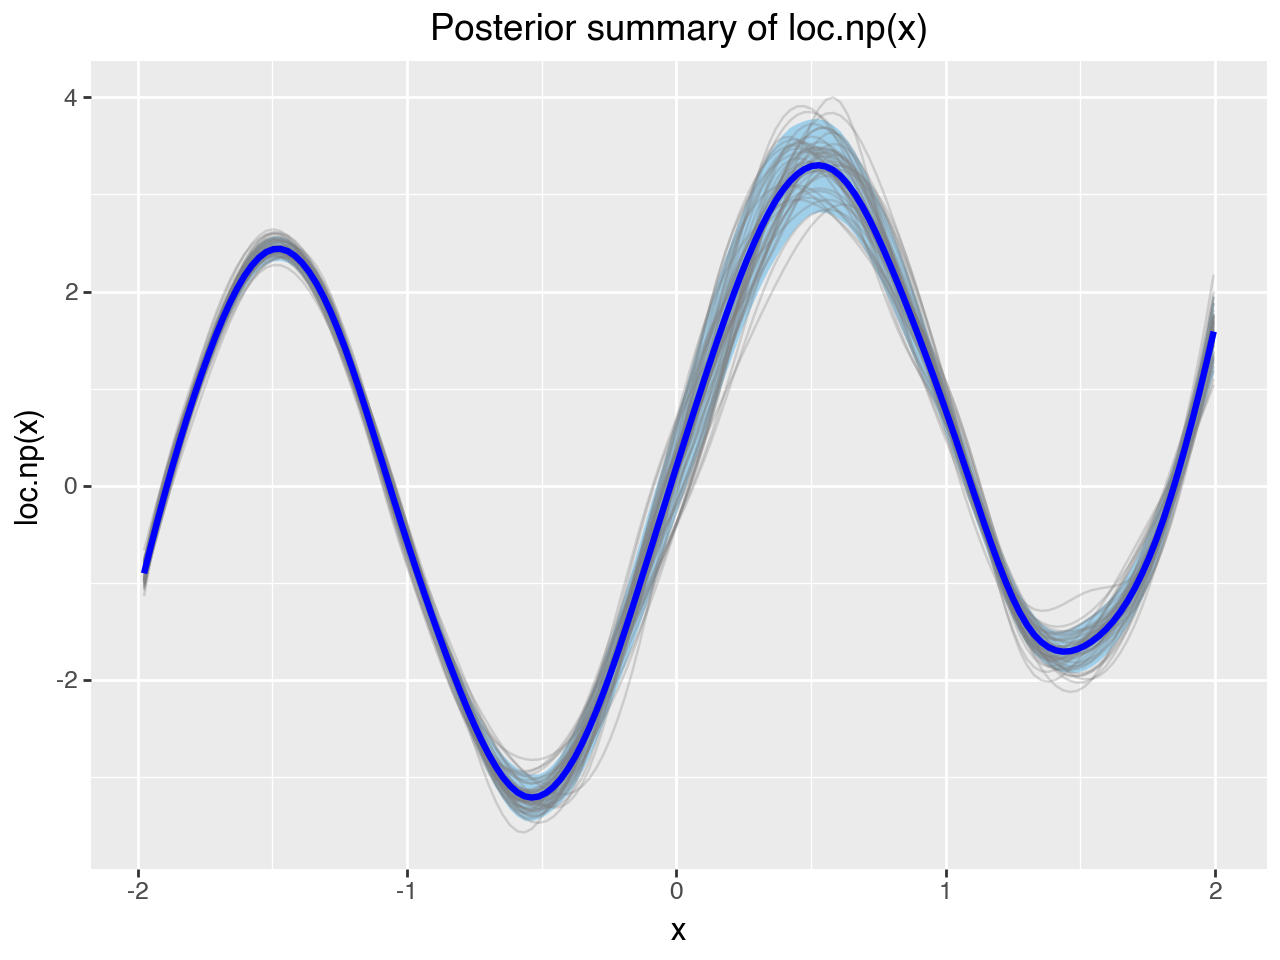

In [10]:
gam.plot_1d_smooth(term=model.vars["loc.np(x)"], samples=samples)

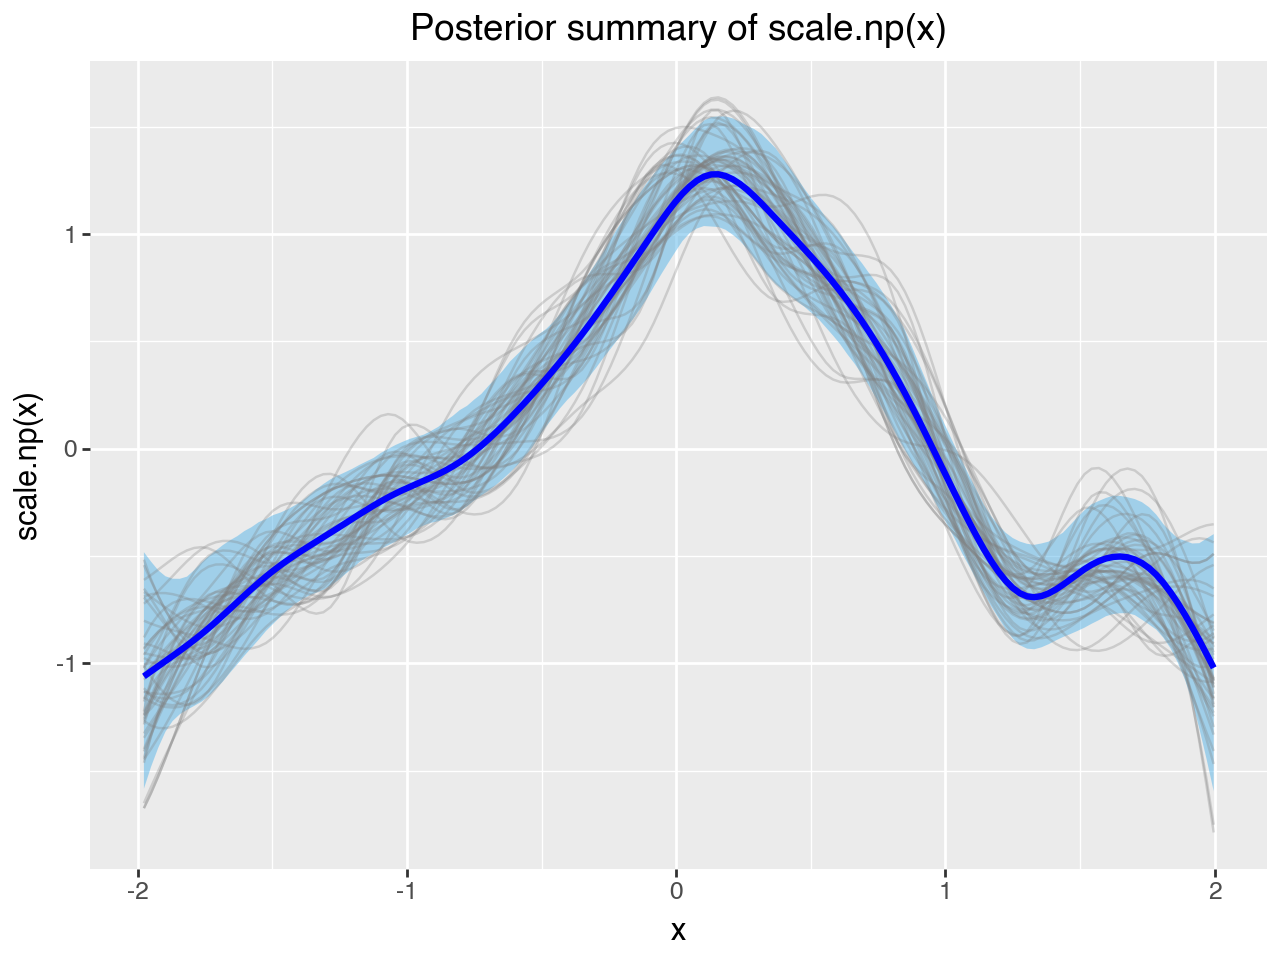

In [11]:
gam.plot_1d_smooth(term=model.vars["scale.np(x)"], samples=samples)